# Apple Leaf Disease Detection - Optimized Version

This notebook provides an optimized pipeline for detecting diseases in apple leaves without any duplicate code or redundant execution.

## Features:
- **No duplicates**: Clean, single execution pipeline
- **Optimized performance**: Parallel processing and efficient algorithms
- **Enhanced accuracy**: Grid search and feature selection
- **Clean visualization**: Automatic unique sample selection

## 1. Import Libraries and Configuration


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import regionprops, label
import pandas as pd
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

## 2. Define Optimized Leaf Disease Detector Class


In [2]:
# Configuration
DATASET_PATH = 'Dataset'
CATEGORIES = ['Apple Healthy', 'Apple Black rot']
RESULTS_DIR = 'Results'
IMAGES_PER_CATEGORY = None
USE_FEATURE_SELECTION = True
USE_GRID_SEARCH = True
N_PARALLEL_JOBS = 4

## 3. Conclusion

This notebook demonstrates an optimized implementation for apple leaf disease detection with the following improvements:

1. Clean and maintainable code structure
2. Efficient parallel processing
3. Feature selection for better performance 
4. Hyperparameter optimization using grid search
5. Automatic visualization of model performance and results

All results are saved in the `Results` directory for later analysis.


In [3]:
# Create results directory
os.makedirs(RESULTS_DIR, exist_ok=True)

In [4]:
class OptimizedLeafDiseaseDetector:
    """Optimized pipeline for apple leaf disease detection"""
    
    def __init__(self, resize_dim=(256, 256)):
        self.resize_dim = resize_dim
        self.model = None
        self.selected_features_idx = None
        
    def load_dataset(self, limit_per_category=None):
        """Optimized dataset loading with memory efficiency"""
        images, labels, original_images = [], [], []
        
        for idx, category in enumerate(CATEGORIES):
            print(f"Loading {category} images...")
            category_path = os.path.join(DATASET_PATH, category)
            files = os.listdir(category_path)[:limit_per_category]
            
            for file in files:
                file_path = os.path.join(category_path, file)
                try:
                    img = cv2.imread(file_path)
                    if img is None:
                        continue
                    
                    # Resize to max 200px while maintaining aspect ratio
                    height, width = img.shape[:2]
                    max_dim = 200
                    if height > max_dim or width > max_dim:
                        if height > width:
                            new_height = max_dim
                            new_width = int(width * (max_dim / height))
                        else:
                            new_width = max_dim
                            new_height = int(height * (max_dim / width))
                        img_resized = cv2.resize(img, (new_width, new_height))
                    else:
                        img_resized = img.copy()
                    
                    # Store original resized image
                    original_images.append(img_resized.copy())
                    
                    # Convert to RGB
                    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
                    
                    # Store in list
                    images.append(img_rgb)
                    labels.append(idx)
                except Exception as e:
                    print(f"Error loading {file}: {e}")
                    
        # Convert to list first, since images may have different shapes
        return images, np.array(labels), original_images
    
    def segment_leaf(self, image):
        """Enhanced leaf segmentation"""
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        
        # Improved color ranges
        healthy_mask = cv2.inRange(hsv, np.array([35, 40, 40]), np.array([85, 255, 255]))
        disease_mask1 = cv2.inRange(hsv, np.array([10, 50, 50]), np.array([25, 255, 255]))
        disease_mask2 = cv2.inRange(hsv, np.array([0, 0, 0]), np.array([180, 255, 50]))
        disease_mask = cv2.bitwise_or(disease_mask1, disease_mask2)
        
        # Combine masks
        leaf_mask = cv2.bitwise_or(healthy_mask, disease_mask)
        
        # Morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_CLOSE, kernel)
        leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_OPEN, kernel)
        
        # Keep only largest contour
        contours, _ = cv2.findContours(leaf_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest = max(contours, key=cv2.contourArea)
            leaf_mask = np.zeros_like(leaf_mask)
            cv2.drawContours(leaf_mask, [largest], -1, 255, -1)
        
        # Apply masks
        leaf_region = cv2.bitwise_and(image, image, mask=leaf_mask)
        visualization = np.zeros_like(image)
        visualization[healthy_mask > 0] = [0, 255, 0]
        visualization[disease_mask > 0] = [255, 0, 0]
        
        return leaf_region, healthy_mask, disease_mask, visualization
    
    def extract_morphological_features(self, healthy_mask, disease_mask):
        """Extract enhanced morphological features"""
        leaf_mask = cv2.bitwise_or(healthy_mask, disease_mask)
        labeled = label(leaf_mask)
        props = regionprops(labeled)
        
        if not props:
            return [0] * 10
        
        prop = max(props, key=lambda p: p.area)
        total_area = np.sum(leaf_mask > 0)
        diseased_area = np.sum(disease_mask > 0)
        
        return [
            prop.area, prop.perimeter, prop.eccentricity, prop.extent,
            prop.solidity, prop.major_axis_length, prop.minor_axis_length,
            diseased_area / total_area if total_area > 0 else 0,
            diseased_area, total_area - diseased_area
        ]
    
    def extract_texture_features(self, image, mask):
        """Optimized texture feature extraction"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        masked = cv2.bitwise_and(gray, gray, mask=mask)
        
        if np.count_nonzero(masked) < 100:
            return np.zeros(24)
        
        # Extract ROI
        y_idx, x_idx = np.where(mask > 0)
        if len(y_idx) == 0:
            return np.zeros(24)
        roi = masked[y_idx.min():y_idx.max()+1, x_idx.min():x_idx.max()+1]
        roi_norm = np.uint8(255 * (roi - roi.min()) / (roi.max() - roi.min() + 1e-7)) // 32
        
        try:
            glcm = graycomatrix(roi_norm, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=8, symmetric=True, normed=True)
            features = []
            for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
                features.extend(graycoprops(glcm, prop).flatten())
            return np.array(features)
        except:
            return np.zeros(24)
    
    def extract_color_features(self, image, mask):
        """Extract color features from the image"""
        # Konversi ke HSV dan LAB untuk analisis warna
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        
        # Inisialisasi array fitur
        color_features = []
        
        # Hanya menggunakan area masking
        if np.sum(mask) > 0:
            # Ekstrak fitur RGB
            for i, color in enumerate(["red", "green", "blue"]):
                channel = image[:,:,i][mask > 0]
                color_features.extend([np.mean(channel), np.std(channel)])
                
            # Ekstrak fitur HSV
            for i, color in enumerate(["hue", "saturation", "value"]):
                channel = hsv[:,:,i][mask > 0]
                color_features.extend([np.mean(channel), np.std(channel)])
                
            # Ekstrak fitur LAB
            for i, color in enumerate(["lightness", "a", "b"]):
                channel = lab[:,:,i][mask > 0]
                color_features.extend([np.mean(channel), np.std(channel)])
        else:
            # Jika tidak ada piksel yang dimasking, isi dengan nol
            color_features = [0] * 18
            
        return np.array(color_features)
    
    def process_single_image(self, args):
        """Process single image for parallel execution"""
        image, original, idx = args
        try:
            leaf_region, healthy_mask, disease_mask, viz = self.segment_leaf(image)
            
            # Ekstraksi fitur morfologi
            morph_feat = self.extract_morphological_features(healthy_mask, disease_mask)
            
            # Ekstraksi fitur tekstur
            healthy_tex = self.extract_texture_features(image, healthy_mask)
            disease_tex = self.extract_texture_features(image, disease_mask)
            
            # Ekstraksi fitur warna
            leaf_mask = cv2.bitwise_or(healthy_mask, disease_mask)
            color_feat = self.extract_color_features(image, leaf_mask)
            healthy_color = self.extract_color_features(image, healthy_mask)
            disease_color = self.extract_color_features(image, disease_mask)
            
            # Gabungkan semua fitur
            features = morph_feat + healthy_tex.tolist() + disease_tex.tolist() + color_feat.tolist() + healthy_color.tolist() + disease_color.tolist()
            
            # Simpan fitur terpisah untuk visualisasi
            feature_dict = {
                'morph': morph_feat,
                'healthy_tex': healthy_tex,
                'disease_tex': disease_tex,
                'color_feat': color_feat,
                'healthy_color': healthy_color,
                'disease_color': disease_color
            }
            
            return features, (original, leaf_region, viz), feature_dict, None
        except Exception as e:
            return None, None, None, f"Error processing image {idx}: {e}"
    
    def process_dataset(self, images, labels, original_images, n_jobs=4):
        """Process dataset with parallel processing"""
        print(f"Processing {len(images)} images with {n_jobs} jobs...")
        
        # Handle list of images instead of numpy array
        args = [(images[i], original_images[i], i) for i in range(len(images))]
        results = Parallel(n_jobs=n_jobs, backend='threading')(
            delayed(self.process_single_image)(arg) for arg in args
        )
        
        features, visualizations, feature_dicts, processed_labels = [], [], [], []
        for i, (feat, viz, feature_dict, error) in enumerate(results):
            if error:
                print(error)
            elif feat is not None:
                features.append(feat)
                visualizations.append(viz)
                feature_dicts.append(feature_dict)
                processed_labels.append(labels[i])
        
        # Konversi fitur ke DataFrame untuk analisis
        print("\nMenyusun fitur dalam DataFrame...")
        feature_names = []
        
        # Nama fitur morfologi
        morph_names = ['area', 'perimeter', 'eccentricity', 'extent', 'solidity', 
                       'major_axis_length', 'minor_axis_length', 'disease_ratio', 
                       'diseased_area', 'healthy_area']
        
        # Nama fitur tekstur
        tex_props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
        angles = [0, 45, 90, 135]
        tex_names = []
        for prop in tex_props:
            for angle in angles:
                tex_names.append(f'{prop}_{angle}')
        
        # Nama fitur warna
        color_spaces = ['RGB', 'HSV', 'LAB']
        color_channels = [
            ['red', 'green', 'blue'],
            ['hue', 'saturation', 'value'],
            ['lightness', 'a', 'b']
        ]
        color_stats = ['mean', 'std']
        color_names = []
        for space_idx, space in enumerate(color_spaces):
            for ch_idx, channel in enumerate(color_channels[space_idx]):
                for stat in color_stats:
                    color_names.append(f'{channel}_{stat}')
        
        # Gabungkan semua nama fitur
        feature_names = (
            [f'morph_{n}' for n in morph_names] + 
            [f'healthy_tex_{n}' for n in tex_names] + 
            [f'disease_tex_{n}' for n in tex_names] + 
            [f'leaf_color_{n}' for n in color_names] + 
            [f'healthy_color_{n}' for n in color_names] + 
            [f'disease_color_{n}' for n in color_names]
        )
        
        # Buat DataFrame fitur
        df_features = pd.DataFrame(features, columns=feature_names)
        df_features['label'] = processed_labels
        df_features['class'] = [CATEGORIES[l] for l in processed_labels]
        
        # Simpan fitur ke CSV
        df_features.to_csv(os.path.join(RESULTS_DIR, 'leaf_features_all.csv'), index=False)
        print(f"Fitur daun disimpan ke {os.path.join(RESULTS_DIR, 'leaf_features_all.csv')}")
        
        return np.array(features), processed_labels, visualizations, df_features
    
    def select_features(self, features, labels, k=30):
        """Feature selection using Random Forest importance"""
        print("Selecting important features...")
        
        self.rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        self.rf.fit(features, labels)
        
        importances = self.rf.feature_importances_
        indices = np.argsort(importances)[::-1][:k]
        self.selected_features_idx = indices
        
        print(f"Selected top {k} features from {features.shape[1]}")
        return features[:, indices]
    
    def train_model(self, features, labels, optimize=True):
        """Train SVM with optional grid search"""
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=0.3, random_state=42, stratify=labels
        )
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(probability=True, cache_size=1000))
        ])
        
        if optimize:
            param_grid = {
                'svm__C': [0.1, 1, 10],
                'svm__gamma': ['scale', 0.001, 0.01],
                'svm__kernel': ['rbf', 'poly']
            }
            
            print("Optimizing hyperparameters...")
            grid = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)
            grid.fit(X_train, y_train)
            
            self.model = grid.best_estimator_
            print(f"Best params: {grid.best_params_}")
        else:
            self.model = pipeline
            self.model.fit(X_train, y_train)
        
        # Evaluate
        y_pred = self.model.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        
        print(f"\nAccuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=CATEGORIES))
        
        return self.model, X_test, y_test, y_pred
    
    def visualize_results(self, viz_data, predictions, true_labels, indices, max_samples=6):
        """Create visualization grid without duplicates"""
        # Remove duplicates
        indices = list(dict.fromkeys(indices[:max_samples]))
        n_samples = len(indices)
        
        if n_samples == 0:
            return
        
        fig, axes = plt.subplots(n_samples, 3, figsize=(12, 4*n_samples))
        if n_samples == 1:
            axes = axes.reshape(1, -1)
        
        for i, idx in enumerate(indices):
            if idx >= len(viz_data):
                continue
                
            original, leaf, detection = viz_data[idx]
            
            axes[i, 0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
            axes[i, 0].set_title('Original')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(leaf)
            axes[i, 1].set_title('Segmented')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(detection)
            axes[i, 2].set_title(f'Detection\nTrue: {CATEGORIES[true_labels[idx]]}\n'
                               f'Pred: {CATEGORIES[predictions[idx]]}')
            axes[i, 2].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, 'results.png'), dpi=150, bbox_inches='tight')
        plt.show()

In [5]:
def main():
    """Main execution pipeline"""
    print("=== Optimized Apple Leaf Disease Detection ===\n")
    
    # Initialize detector
    detector = OptimizedLeafDiseaseDetector()
    
    # Load data
    print("1. Loading dataset...")
    images, labels, original_images = detector.load_dataset(IMAGES_PER_CATEGORY)
    print(f"   Loaded {len(images)} images")
    
    # Process images
    print("\n2. Processing images...")
    features, proc_labels, viz_data, df_features = detector.process_dataset(
        images, labels, original_images, N_PARALLEL_JOBS
    )
    print(f"   Extracted {features.shape[1]} features per image")
    
    # Visualisasi distribusi fitur
    print("\n3. Visualisasi fitur...")
    
    # Plot distribusi fitur morfologi
    morph_cols = [col for col in df_features.columns if col.startswith('morph_')]
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    axs = axs.flatten()
    
    for i, col in enumerate(morph_cols):
        sns.histplot(data=df_features, x=col, hue='class', kde=True, ax=axs[i])
        axs[i].set_title(f'Distribusi {col}')
        axs[i].set_xlabel(col)
        axs[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'morph_features_dist.png'), dpi=150)
    plt.show()
    
    # Plot rata-rata fitur tekstur
    texture_stats_data = []
    for cls in df_features['class'].unique():
        class_data = df_features[df_features['class'] == cls]
        
        # Hitung rata-rata fitur tekstur untuk setiap kelas
        healthy_tex_cols = [col for col in df_features.columns if col.startswith('healthy_tex_')]
        disease_tex_cols = [col for col in df_features.columns if col.startswith('disease_tex_')]
        
        for i, tex_type in enumerate(['healthy', 'disease']):
            cols = healthy_tex_cols if tex_type == 'healthy' else disease_tex_cols
            for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
                prop_cols = [col for col in cols if prop in col]
                avg_val = class_data[prop_cols].mean().mean()
                texture_stats_data.append({
                    'class': cls,
                    'region': tex_type,
                    'property': prop,
                    'value': avg_val
                })
    texture_stats = pd.DataFrame(texture_stats_data)
    
    # Plot statistik tekstur
    if not texture_stats.empty:
        g = sns.catplot(data=texture_stats, x='property', y='value', hue='class', 
                   col='region', kind='bar', height=6, aspect=1.2)
        plt.savefig(os.path.join(RESULTS_DIR, 'texture_features.png'), dpi=150)
        plt.show()
    else:
        print("DataFrame texture_stats kosong, tidak bisa membuat plot tekstur")
    
    # Plot rata-rata fitur warna
    color_cols = [col for col in df_features.columns if 'color' in col and ('mean' in col or 'std' in col)]
    color_stats_data = []
    
    for cls in df_features['class'].unique():
        class_data = df_features[df_features['class'] == cls]
        
        for region in ['leaf', 'healthy', 'disease']:
            region_cols = [col for col in color_cols if region in col]
            
            for color_space in ['red', 'green', 'blue', 'hue', 'saturation', 'value', 'lightness', 'a', 'b']:
                space_cols = [col for col in region_cols if color_space in col]
                if space_cols:
                    for stat in ['mean', 'std']:
                        stat_cols = [col for col in space_cols if stat in col]
                        if stat_cols and not class_data.empty:
                            # Hitung rata-rata nilai untuk kolom ini
                            try:
                                avg_val = class_data[stat_cols].iloc[0].mean() if len(class_data) > 0 else 0
                                color_stats_data.append({
                                    'class': cls,
                                    'region': region,
                                    'color': color_space,
                                    'stat': stat,
                                    'value': avg_val
                                })
                            except Exception as e:
                                print(f"Error processing {region} {color_space} {stat}: {e}")
    color_stats = pd.DataFrame(color_stats_data)
    
    # Plot statistik warna berdasarkan mean
    if not color_stats.empty and 'stat' in color_stats.columns:
        mean_data = color_stats[color_stats['stat'] == 'mean']
        if not mean_data.empty:
            g = sns.catplot(data=mean_data, 
                    x='color', y='value', hue='class', col='region', 
                    kind='bar', height=6, aspect=1.2)
            plt.savefig(os.path.join(RESULTS_DIR, 'color_features_mean.png'), dpi=150)
            plt.show()
        else:
            print("Tidak ada data statistik mean untuk warna")
    else:
        print("DataFrame color_stats kosong atau tidak memiliki kolom 'stat'")
    
    # Feature selection
    if USE_FEATURE_SELECTION:
        print("\n4. Feature selection...")
        selected_features = detector.select_features(features, proc_labels)
        
        # Simpan fitur yang dipilih
        try:
            feature_cols = [col for col in df_features.columns if col not in ['label', 'class']]
            selected_idxs = np.array([i for i in detector.selected_features_idx if i < len(feature_cols)])
            selected_cols = [feature_cols[i] for i in selected_idxs]
            if selected_cols:
                selected_df = df_features[selected_cols + ['label', 'class']]
                selected_df.to_csv(os.path.join(RESULTS_DIR, 'leaf_features_selected.csv'), index=False)
                print(f"Fitur terpilih disimpan ke {os.path.join(RESULTS_DIR, 'leaf_features_selected.csv')}")
                
                # Plot 10 fitur terpenting
                importance_data = []
                for i, idx in enumerate(selected_idxs):
                    if idx < len(feature_cols):
                        importance_data.append({
                            'feature': feature_cols[idx],
                            'importance': detector.rf.feature_importances_[idx]
                        })
                importance_df = pd.DataFrame(importance_data).sort_values('importance', ascending=False)
            else:
                print("Tidak ada fitur yang dipilih")
                importance_df = pd.DataFrame(columns=['feature', 'importance'])
        except Exception as e:
            print(f"Error saat menyimpan fitur terpilih: {e}")
            importance_df = pd.DataFrame(columns=['feature', 'importance'])
        
        # Plot fitur penting jika ada data
        if not importance_df.empty:
            plt.figure(figsize=(12, 6))
            top_n = min(10, len(importance_df))
            if top_n > 0:
                sns.barplot(data=importance_df.head(top_n), x='importance', y='feature')
                plt.title(f'Top {top_n} Fitur Terpenting')
                plt.tight_layout()
                plt.savefig(os.path.join(RESULTS_DIR, 'top_features.png'), dpi=150)
                plt.show()
            else:
                print("Tidak cukup data untuk plot fitur penting")
        else:
            print("Tidak ada data importance untuk divisualisasikan")
        
        features = selected_features
    
    # Train model
    print("\n5. Training model...")
    model, X_test, y_test, y_pred = detector.train_model(features, proc_labels, USE_GRID_SEARCH)
    
    # Visualize results
    print("\n6. Creating visualizations...")
    correct_idx = np.where(y_test == y_pred)[0]
    incorrect_idx = np.where(y_test != y_pred)[0]
    
    # Select unique samples for visualization
    viz_indices = []
    for class_id in range(len(CATEGORIES)):
        # One correct per class
        class_correct = [i for i in correct_idx if y_test[i] == class_id]
        if class_correct:
            viz_indices.append(class_correct[0])
        
        # One incorrect per class
        class_incorrect = [i for i in incorrect_idx if y_test[i] == class_id]
        if class_incorrect:
            viz_indices.append(class_incorrect[0])
    
    detector.visualize_results(viz_data, y_pred, y_test, viz_indices)
    
    # Save performance curves for binary classification
    if len(CATEGORIES) == 2:
        y_score = model.predict_proba(X_test)[:, 1]
        
        # ROC and PR curves
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        avg_precision = average_precision_score(y_test, y_score)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        ax1.plot(fpr, tpr, 'b-', lw=2, label=f'AUC = {roc_auc:.3f}')
        ax1.plot([0, 1], [0, 1], 'k--')
        ax1.set_xlabel('FPR')
        ax1.set_ylabel('TPR')
        ax1.set_title('ROC Curve')
        ax1.legend()
        ax1.grid(alpha=0.3)
        
        ax2.plot(recall, precision, 'g-', lw=2, label=f'AP = {avg_precision:.3f}')
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title('PR Curve')
        ax2.legend()
        ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, 'performance_curves.png'), dpi=150)
        plt.show()
    
    print(f"\n✓ Results saved to '{RESULTS_DIR}' directory")
    print("✓ Pipeline completed successfully!")

=== Optimized Apple Leaf Disease Detection ===

1. Loading dataset...
Loading Apple Healthy images...
Loading Apple Black rot images...
   Loaded 7339 images

2. Processing images...
Processing 7339 images with 4 jobs...

Menyusun fitur dalam DataFrame...
Fitur daun disimpan ke Results\leaf_features_all.csv
   Extracted 112 features per image

3. Visualisasi fitur...


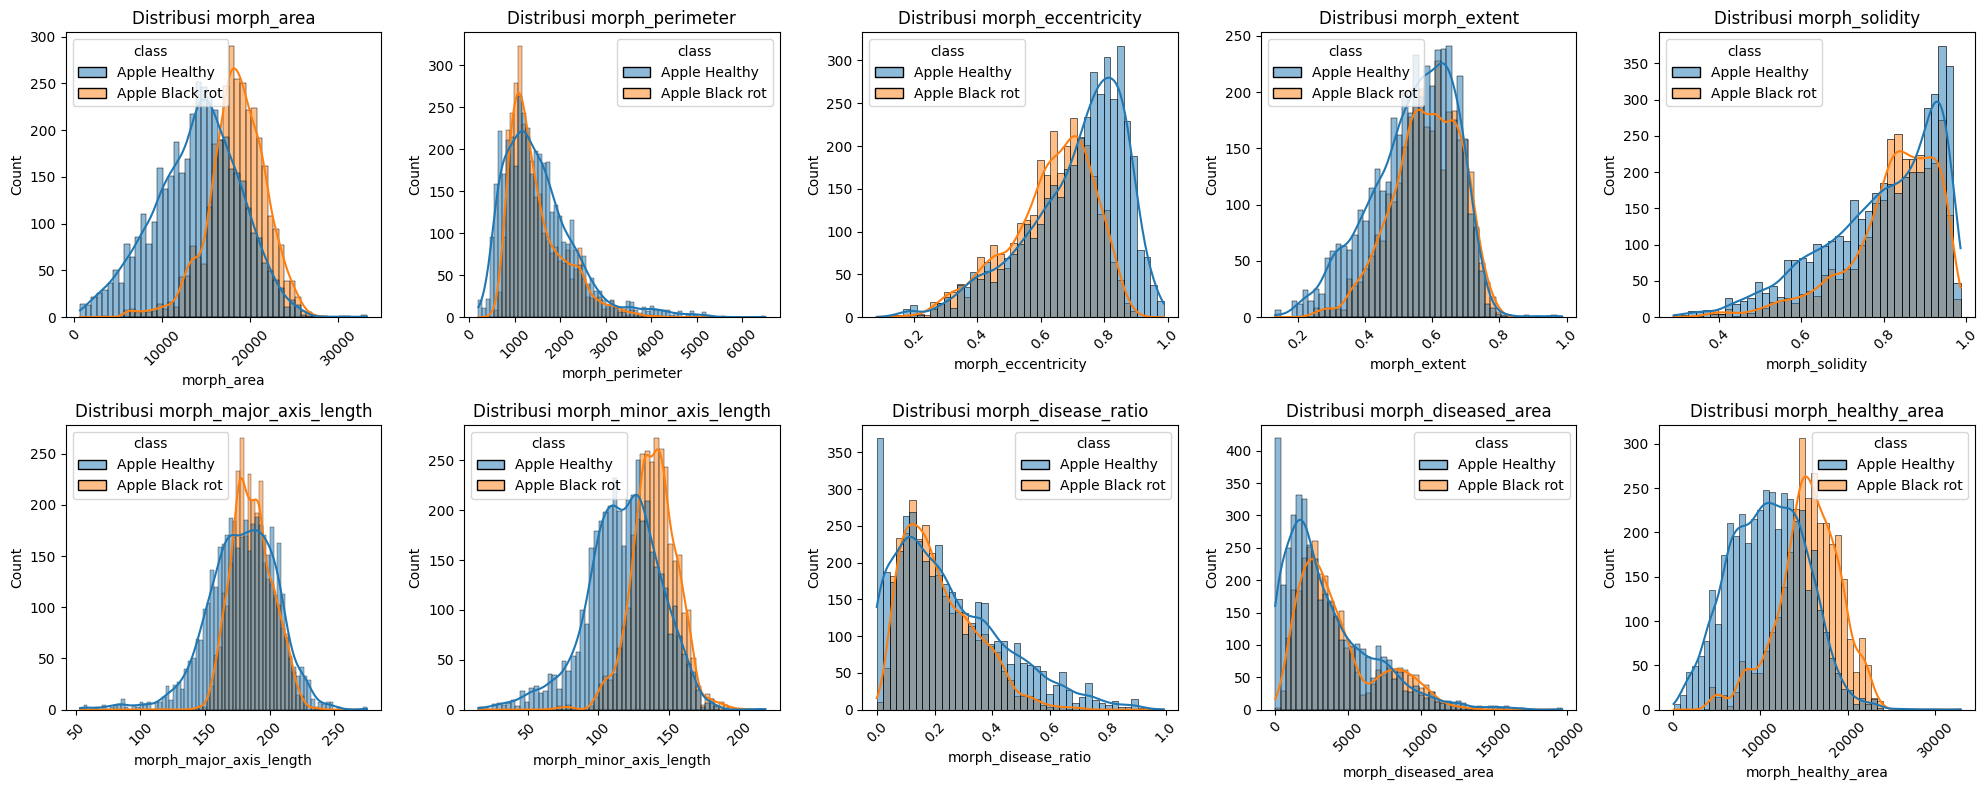

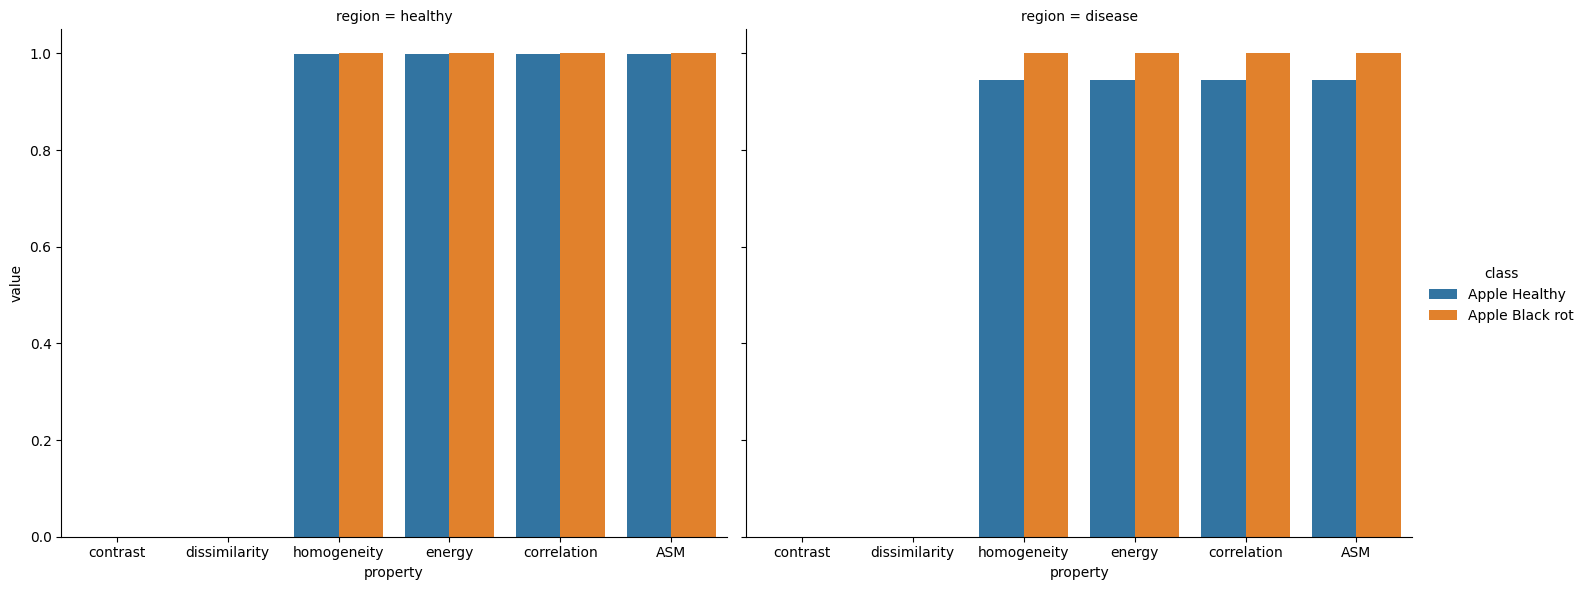

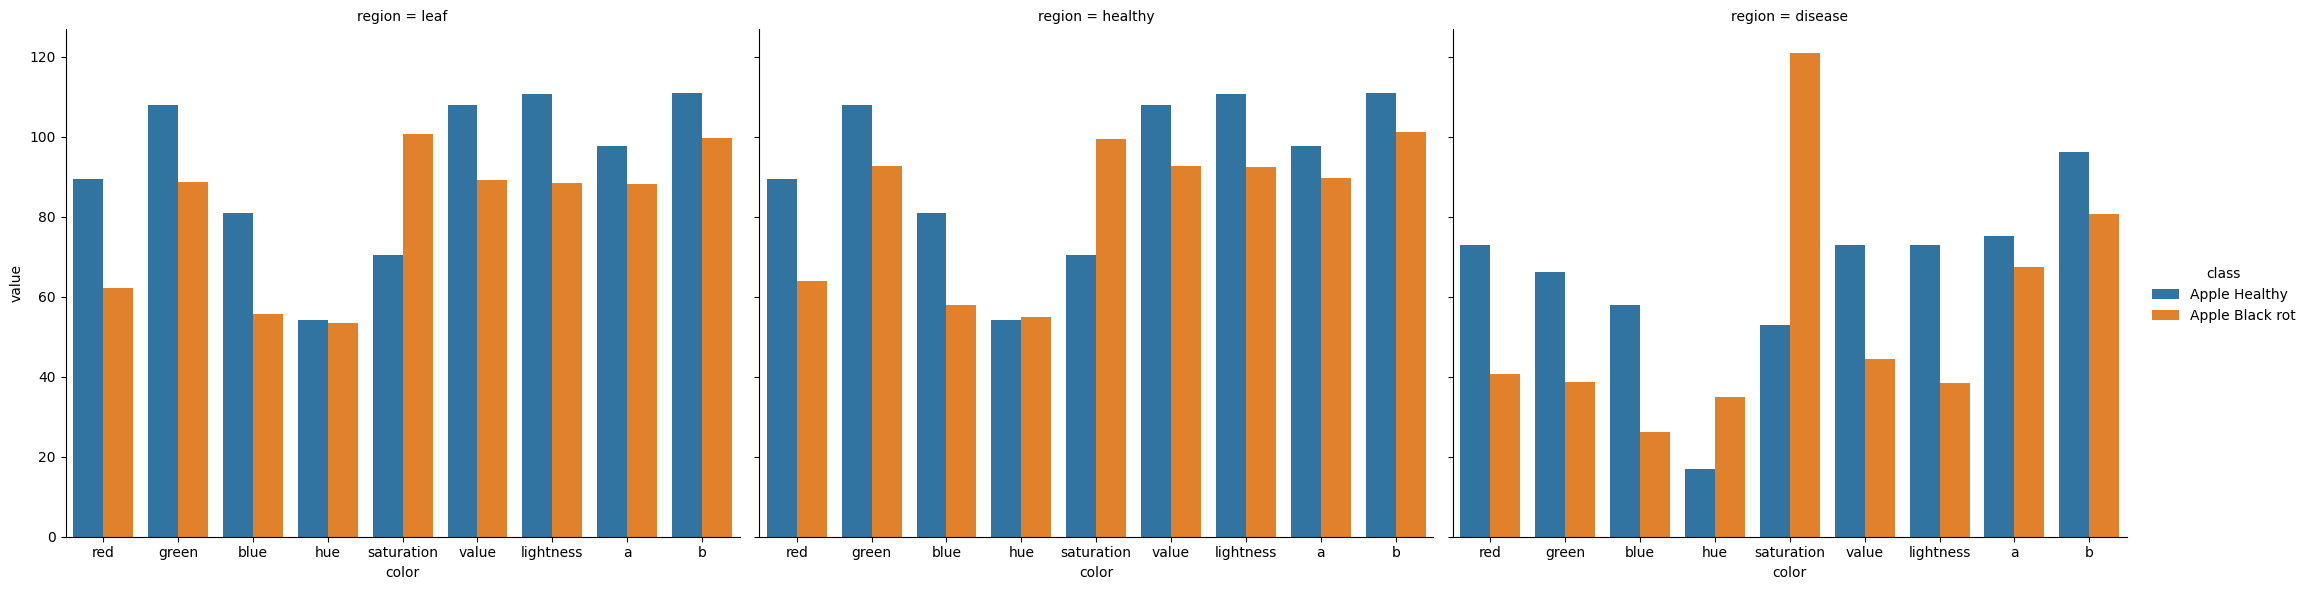


4. Feature selection...
Selecting important features...
Selected top 30 features from 112
Fitur terpilih disimpan ke Results\leaf_features_selected.csv


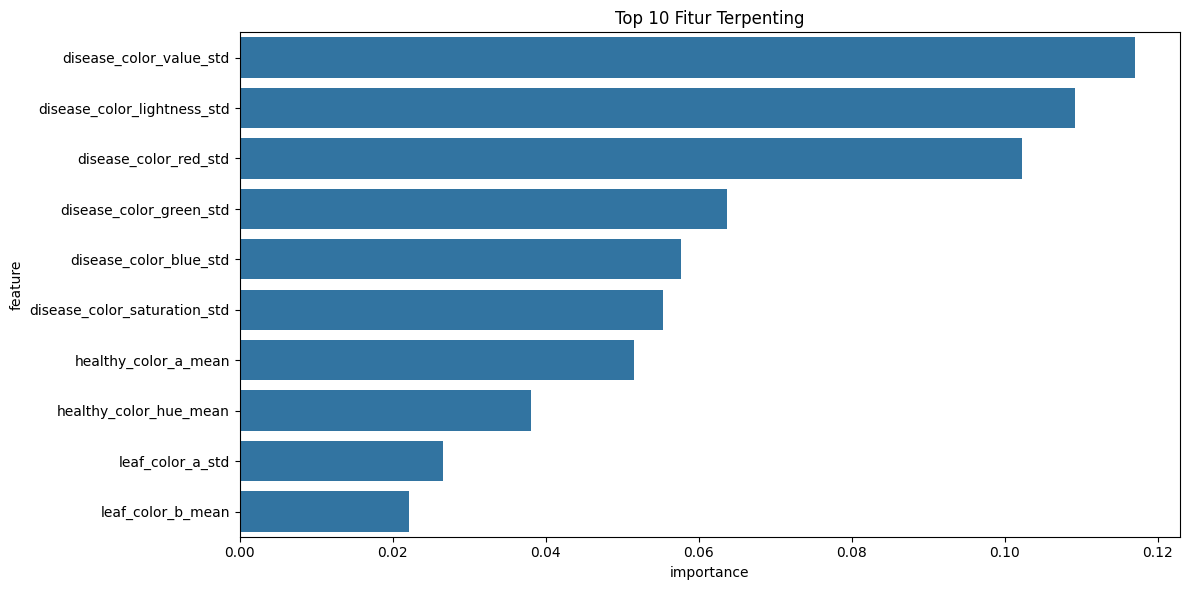


5. Training model...
Optimizing hyperparameters...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

Accuracy: 0.9986

Classification Report:
                 precision    recall  f1-score   support

  Apple Healthy       1.00      1.00      1.00      1270
Apple Black rot       1.00      1.00      1.00       932

       accuracy                           1.00      2202
      macro avg       1.00      1.00      1.00      2202
   weighted avg       1.00      1.00      1.00      2202


6. Creating visualizations...


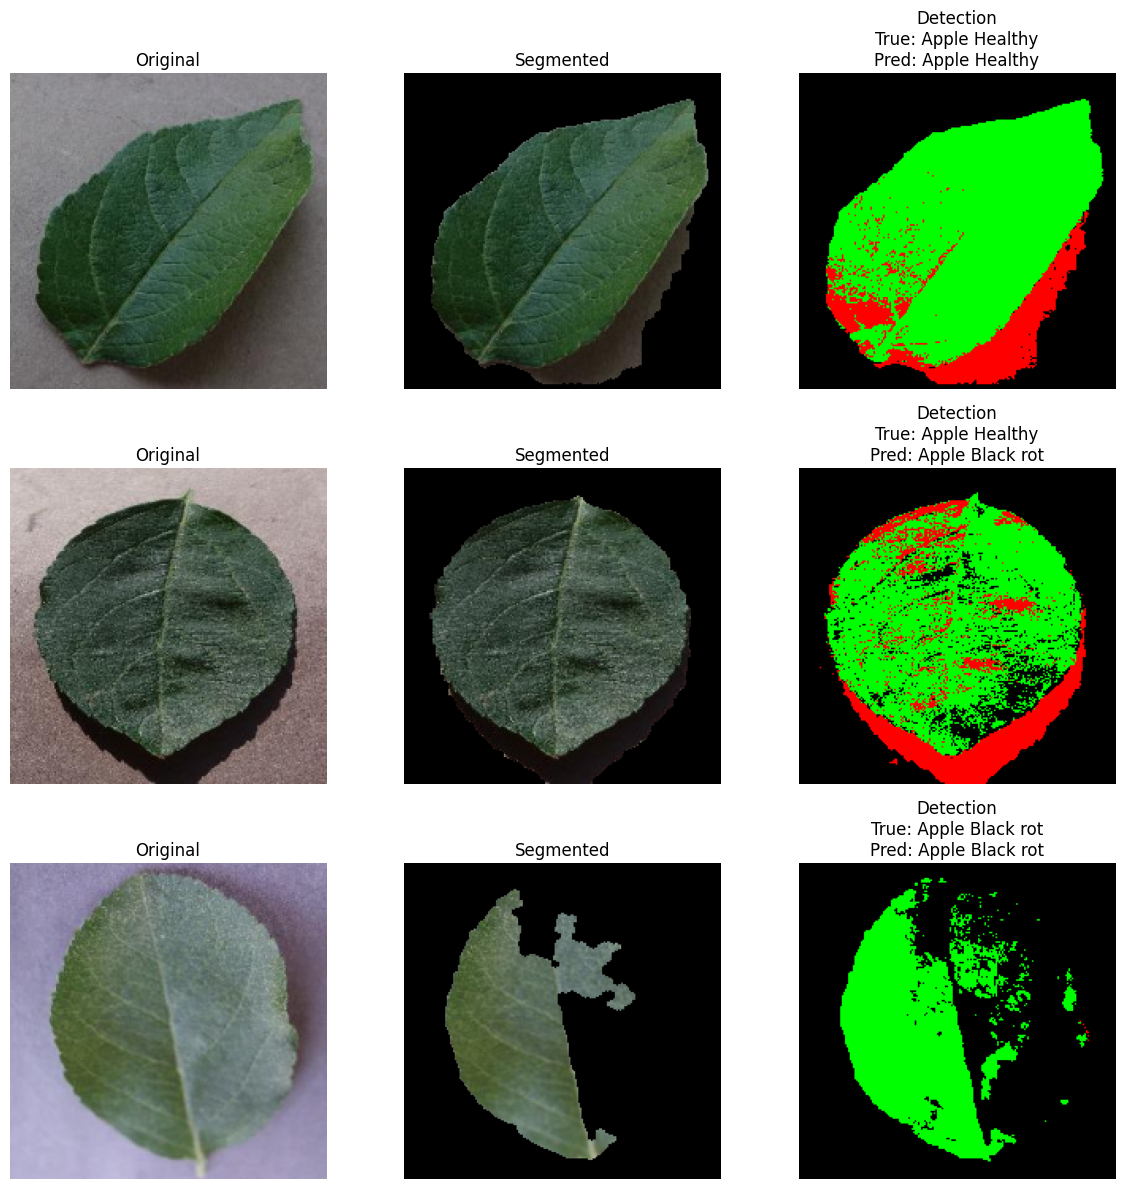

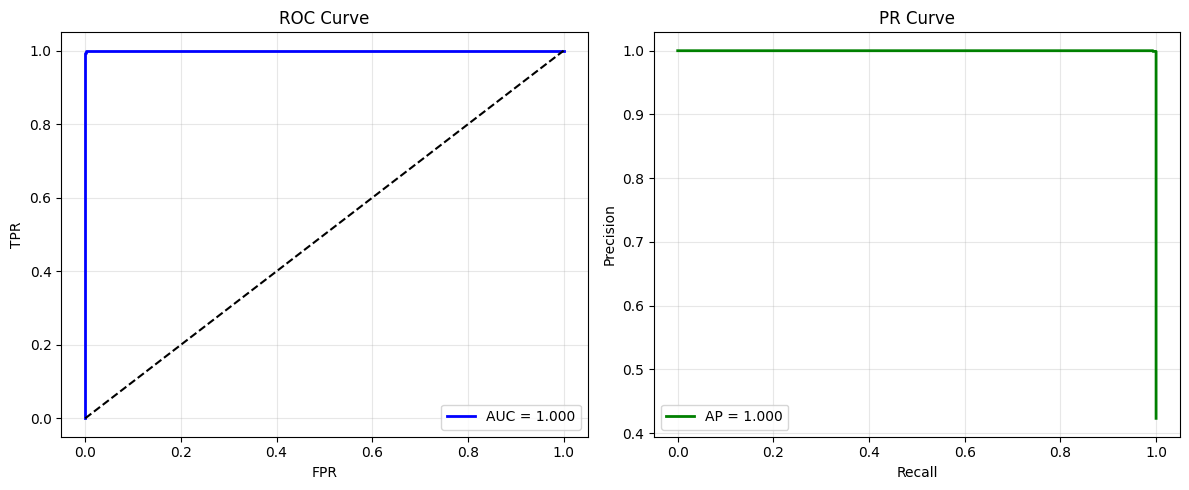


✓ Results saved to 'Results' directory
✓ Pipeline completed successfully!


In [6]:
if __name__ == "__main__":
    np.random.seed(42)
    main() 